# Forecasting sales of breakfast items in Apollo Hospital using feed-forward neural network with entity embedding

## Introduction

In [another notebook](https://github.com/richardblythman/hospital-breakfast-forecast/blob/master/arima-models.ipynb), classical ARIMA models were used to forecast the sale of breakfast items in an Apollo hospital to provide a baseline for evaluating the accuracy of a neural network on the very small dataset. In many ways, modern machine learning constitutes a paradigm shift with respect to classical statistical techniques. The aim of the current notebook is to use as little data exploration, feature engineering and domain expertise as possible, to achieve a "black box" model with comparable accuracy.

A simple feed-forward neural network with entity embedding is chosen, since such models have been outperforming recurrent neural networks in recent times. For example, neural networks with categorical embedding have been successfully applied to time series data by the winners and 3rd place runners-up of the [New York City Taxi Fare Prediction](http://blog.kaggle.com/2015/07/27/taxi-trajectory-winners-interview-1st-place-team-%F0%9F%9A%95/) ([paper here](https://arxiv.org/abs/1508.00021)) and [Rosmann Store Sales](http://blog.kaggle.com/2016/01/22/rossmann-store-sales-winners-interview-3rd-place-cheng-gui/) ([paper here](https://arxiv.org/abs/1604.06737)) competitions on Kaggle. The current implementation is based on the [Lesson 3 Jupyter notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb) of the [Practical Deep Learning for Coders](http://course.fast.ai/), using the newly-released [fastai v1.0](https://github.com/fastai/fastai) deep learning library (which sits on top of PyTorch v1). 

## Preparations

### Load libraries

For this structured data problem, we'll use the fastai tabular modules.

In [1]:
%matplotlib inline

from fastai import *
from fastai.tabular import *

from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data manipulation

### Load data files

Firstly, let's read the raw data and convert the dates to a usable format.

In [2]:
df_ = pd.read_csv('./data/IMB.csv')
df_["Date"] = pd.to_datetime(df_.Date, format="%d/%m/%Y")

num_days = len(df_)
item_names = df_.columns[2:9].values
num_items = len(item_names)

print("Number of missing values: ", df_.isnull().sum().sum())
print("Shape: ",df_.shape)
df_.tail()

Number of missing values:  0
Shape:  (115, 9)


,Date,Occupancy,Idly,Dosa,Chutney,Sambar,Continental B/F,North Indian B/F,Omelette
110,2013-01-19,198,61,15,127,127,40,3,18
111,2013-01-20,210,65,20,140,140,41,3,22
112,2013-01-21,200,61,14,129,136,41,6,22
113,2013-01-22,230,66,17,128,123,43,7,21
114,2013-01-23,233,44,16,139,139,44,4,17


The data consists of the daily occupancy and sales figures for 7 breakfast items. The dataset is small, spanning less than four months from 1st October 2012 to 23rd January 2013. Luckily, there are no missing values. 

Classical ARIMA models are parametric and require determination of the ARIMA parameters for each breakfast item. In contrast, we can build a single model using deep learning. The data are rearranged with a single target column (i.e. sales) and a new feature column for item number. The advantage of neural networks is that numerous input features, such as occupancy, are easily included.

In [3]:
bkfst_map = {0:'Idly',1:'Dosa',2:'Chutney',3:'Sambar',4:'Continental B/F',
             5:'North Indian B/F',6:'Omelette'}
num_items = len(bkfst_map)

df = df_.loc[np.repeat(df_.index.values,num_items)]
df = df.reset_index(drop=True)

for i in range(num_days):
    for j in range(num_items):
        df.loc[num_items*i+j,'Item'] = j
        df.loc[num_items*i+j,'Sales'] = df_.loc[i,bkfst_map[j]]

df = df.drop(columns=["Idly","Dosa","Chutney","Sambar","Continental B/F",
                      "North Indian B/F", "Omelette",])        

Let's also include some external data about public holidays in the region (the holiday data is drawn from [here](https://www.officeholidays.com/countries/india/tamil_nadu/index.php)).

In [4]:
holidays = pd.read_csv('./data/public_holidays_Tamil_Nadu.csv') 
holidays["Date"] = pd.to_datetime(holidays.Date, format="%d/%m/%Y")
dates = list(holidays['Date'])

for i in range(num_days*num_items):
    df.loc[i,'PublicHoliday'] = df.loc[i,'Date'] in dates
    
df.tail(10)

,Date,Occupancy,Item,Sales,PublicHoliday
795,2013-01-22,230,4.0,43.0,False
796,2013-01-22,230,5.0,7.0,False
797,2013-01-22,230,6.0,21.0,False
798,2013-01-23,233,0.0,44.0,False
799,2013-01-23,233,1.0,16.0,False
800,2013-01-23,233,2.0,139.0,False
801,2013-01-23,233,3.0,139.0,False
802,2013-01-23,233,4.0,44.0,False
803,2013-01-23,233,5.0,4.0,False
804,2013-01-23,233,6.0,17.0,False


### Feature engineering

In order to capture patterns in the behaviour of patients, a number of higher-level variables more representative of human activity (such as the day of the week) are extracted from the date.

In [5]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 
            'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

add_datepart(df, "Date", drop=False)

The number of days since the last, and until the next public holiday, may also be relevant.

In [6]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    res = []

    for v,d in zip(df[fld].values, df.Date.values):
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [7]:
df = df.sort_values('Date')
get_elapsed('PublicHoliday', 'After')
df = df.sort_values('Date', ascending=False)
get_elapsed('PublicHoliday', 'Before')

# Re-sort in chronological order, and set date as index
df = df.sort_values(['Date','Item'])
df = df.set_index("Date")

# Set the NaN values from the new columns to 0
df[['Before'+'PublicHoliday', 
    'After'+'PublicHoliday']] = df[['Before'+'PublicHoliday', 
                                    'After'+'PublicHoliday']].fillna(0).astype(int)
print("Shape: ",df.shape)
df.head().T

Shape:  (805, 19)


Date,2012-10-01 00:00:00,2012-10-01 00:00:00,2012-10-01 00:00:00,2012-10-01 00:00:00,2012-10-01 00:00:00
Occupancy,250,250,250,250,250
Item,0,1,2,3,4
Sales,40,30,95,95,25
PublicHoliday,False,False,False,False,False
Year,2012,2012,2012,2012,2012
Month,10,10,10,10,10
Week,40,40,40,40,40
Day,1,1,1,1,1
Dayofweek,0,0,0,0,0
Dayofyear,275,275,275,275,275


### Create training, validation and test sets

Since the goal is to reduce food wastage, the validation and test sets are selected using time-based splitting. Using this method, the statistical distributions of the sets are not identical, and an indication of the generalisation ability of the production model is illustrated. Also, the hospital may need a week or more to buy ingredients. Neural networks commonly train separate models for predicting subsequent future time steps. To start, we'll train a model to predict a single day into the future. The test set is chosen as the sales of items during the final day of data.

In [8]:
test_days = 1
test_size = test_days*num_items

test_df = df[-test_size:]
df = df[:-test_size]

size = len(df)

The test set is witheld until the very end, ensuring that that we do not tune the model parameters such that they work better than expected, [by chance](http://www.fast.ai/2017/11/13/validation-sets/). A validation set of the same length is chosen for model tuning.

In [9]:
val_size = test_size
train_df, val_df = df[:-val_size].copy(), df[-val_size:].copy()

## Categorical variables and entity embedding

Neural networks can approximate [any](http://neuralnetworksanddeeplearning.com/chap4.html) arbitrary continuous function, but are not innately suited to approximating non-continuous functions. Structured data with categorical features are not necessarily continuous. While some categories are commonly given integer labels (called nominal numbers) for convenience, they do not necessarily share a continuous relationship and should not be naively treated as such by the alogorithm. For example, dosa is not necessarily bigger than idly and smaller than chutney. Other integer labels (called cardinal or ordinal numbers) do share some continuous relationship, such as the indices for month. However, different months may share some characteristics based on, for example, the number of days within them. Hence, treating date variables as discrete may improve the generalisation of the model.   

In [10]:
dep_var = 'Sales'
cat_names = ['Item', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 
             'Is_year_end', 'Is_year_start', 'PublicHoliday',
             'AfterPublicHoliday', 'BeforePublicHoliday']

Traditionally, one-not encoding has been used to facilitate categorical features in neural networks, although the computational expense is prohibitive for high-cardinality variables. More importantly, this representation fails to capture relationships between categories. Hence, we instead use the [categorical embedding](http://www.fast.ai/2018/04/29/categorical-embeddings/) technique. For illustrative purposes, consider the overly-simplified embeddings below, describing a soup and a salad.

|Item       |Spiciness  |Healthiness|Texture    |
|-----------|-----------|-----------|-----------|
|Soup       |0.9        |0.8        |0.1        |
|Salad      |0.7        |0.9        |0.9        |

Now the separate (non-continuous) meal categories are represented using 3 additional dimensions that are continuous over all meals. Each dimension may be thought of as learnable semantic information about the meal. According to this example, both meals are spicy and healthy so they're represented close to each other in these dimensions. However, a soup is a smooth liquid while a salad is a crunchy solid, so they're far apart in the texture dimension. With such a lack of data about the breakfast items (e.g. type, price, size, nutritional information, spiciness, region of origin) in the current problem, it is especially important to facilitate the learning of these relationships. In practice, it will likely turn out that each dimension captures numerous indistinguishable characteristics. 

To deal with categorical variables, we include Categorify in a a list of TabularTransform objects that will be applied the varables in preprocessing. Then a DataBunch object is created for training.

In [11]:
tfms = [FillMissing, Categorify]
data = TabularDataBunch.from_df("./tmp", train_df, val_df, dep_var, test_df, 
                                tfms=tfms, cat_names=cat_names)

We calculate the dimensions of the embeddings from the category sizes, using the following [rule of thumb](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb). 

In [12]:
# add one to category sizes to allow for None values
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_names] 
emb_szs = {c1:min(50, (c2+1)//2) for c1,c2 in cat_sz}; emb_szs

{'Item': 4,
 'Year': 2,
 'Month': 3,
 'Week': 9,
 'Day': 16,
 'Dayofweek': 4,
 'Dayofyear': 50,
 'Is_month_end': 2,
 'Is_month_start': 2,
 'Is_quarter_end': 2,
 'Is_quarter_start': 2,
 'Is_year_end': 2,
 'Is_year_start': 2,
 'PublicHoliday': 2,
 'AfterPublicHoliday': 14,
 'BeforePublicHoliday': 14}

## Deep learning

Firstly, a simple feed-forward neural network model with two hidden layers (with 25 neurons in each), and the embeddings sizes determined above, is built using a Learner object.

In [13]:
learn = get_tabular_learner(data, layers=[25,25], emb_szs=emb_szs)

To suggest a suitable learning rate, we use the learning rate finder. By default, the function stops when the learning rate explodes.

In [14]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


Now, let's plot the loss function versus learning rate.

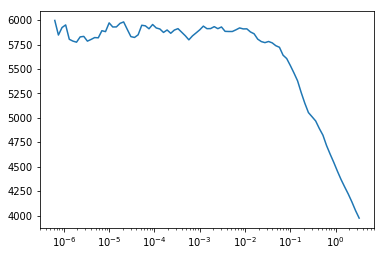

In [15]:
learn.recorder.plot()

The rule of thumb here is to pick an order of magnitude that is roughly at the midpoint of the steepest decreasing slope. It looks like this falls somewhere between $10^{-1}$ and $10^{0}$. Let's use the smaller value since training shouldn't take too long for this problem, and run training for 10 epochs.

In [16]:
learn.fit_one_cycle(15, 1)

Total time: 00:07
epoch  train_loss  valid_loss   
1      3912.124023  52351.519531  (00:00)
2      2067.166992  7039.231934   (00:00)
3      1264.914185  1983.909180   (00:00)
4      878.476379  264.880219     (00:00)
5      650.951111  197.484909     (00:00)
6      505.850708  170.580536     (00:00)
7      404.810608  468.989777     (00:00)
8      361.096130  21.043930      (00:00)
9      293.879730  41.976521      (00:00)
10     238.080231  87.125572      (00:00)
11     208.922012  28.040726      (00:00)
12     179.860687  50.028721      (00:00)
13     157.258392  40.029705      (00:00)
14     133.039581  29.316206      (00:00)
15     125.915413  28.561720      (00:00)



## Results

### Predictions

Finally, we can look at our predictions, in comparison to the target values.

In [17]:
pred, targ = learn.get_preds()
pred, targ = np.round(pred.numpy()), targ.numpy()
results = pd.DataFrame(index = item_names, 
                       data = np.column_stack((targ,pred)), 
                       columns = ['Targets','Predictions'])
results.head(10)

,Targets,Predictions
Idly,66.0,59.0
Dosa,17.0,25.0
Chutney,128.0,126.0
Sambar,123.0,127.0
Continental B/F,43.0,41.0
North Indian B/F,7.0,5.0
Omelette,21.0,13.0


### Visualising embeddings

Out of interest, let's inspect the learned values of the embedding matrix for the item category. 

In [18]:
embs = list()
for param in learn.model.embeds.parameters():
    embs.append(param)
item_emb = embs[0].data[1:].numpy(); item_emb

array([[-0.4176886 , -0.30373386, -0.3204186 ,  0.33330435],
       [ 1.7890958 ,  2.4003048 ,  2.3289754 , -2.246398  ],
       [-2.9193099 , -3.8185925 , -3.4227471 ,  3.495456  ],
       [-2.9792697 , -3.8745937 , -3.5144446 ,  3.6132276 ],
       [ 0.8001354 ,  0.9166291 ,  0.93365335, -0.91012895],
       [ 4.2724543 ,  5.6550097 ,  4.636518  , -5.0178485 ],
       [ 3.5152476 ,  3.9791915 ,  3.7852154 , -3.7645051 ]],
      dtype=float32)

We can already see that the learned embeddings for chutney and sambar (rows 3 and 4) are very similar. Let's visualise the similarity of the breakfast item embeddings in 2-D, by using Principal Component Analysis (PCA) to reduce the dimensionality of this matrix.

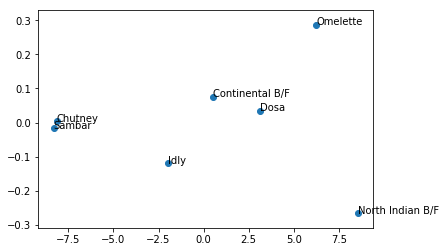

In [19]:
pca = PCA(n_components=2).fit_transform(item_emb)
x, y = pca[:,0], pca[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(item_names):
    ax.annotate(txt, (x[i], y[i]))

Interestingly, we see a number of similar pairings in the two-dimensional representation of the embedding matrix. As expected, sambar and chutney lie close together. Also, idly falls near to continental breakfast, and omelette is close to North Indian breakfast. This imitates behaviour that was observed during the EDA of the previous notebook. It has been found that feeding learned embeddings into other machine learning models [significantly improves their accuracy](https://arxiv.org/abs/1604.06737). 

## Conclusions

It is impressive that the deep neural network performed so well, given just 115 days of noisy data (machine learning techniques are generally considered data hungry). Nonetheless, the efforts that the hospital have gone to in order to collect data are poor by today’s standard, and the model would be much improved with more temporal data and features. For example, the training data of the Recruit Restaurant Visitor Forecasting competition includes sales for about 1.5 years across 829 restaurants. The training data of the Rosmann Store Sales Kaggle competition consists of 1,017,209 individual sales across 1,115 stores, and contains information about store models, promos, and competitors (e.g. distance away, how long their stores have been open).

In the current neural network model, I included information about holidays (e.g. whether it is a holiday, how many days after/before a holiday it is). Going forward, Apollo hospitals could collect and supply information on the dietary requirements of patients, and more information about the meals could be included as features (e.g. price, size, nutritional values, what region of India it's from, whether it's spicy or plain, a soup or a salad). Perhaps, information about the patients themselves, such as their place of birth and age, would improve accuracy (privacy permitting). Also, an feature could be included to indicate whether a dish sold out on a given day. It would be interesting to explore the effects of other features, such as the weather and pollution levels, too. Of course, the model could be scalable to multiple hospital locations using another feature column. 

Interestingly(!), the same recommendations could apply to a POS system. Effective POS software should not only record actual sales, but stock, promotion, and customer information (perhaps through loyalty cards). Hence, POS software that includes machine learning techniques could forecast sales for a particular item in a particular store on a certain date, ensuring that the item is in stock and enabling the retailer to tailor promotional offers. The effect of promotional offers could also be analysed in detail. 


